# Bert NER using BIO format
This notebook follows the tutorial: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/?fbclid=IwAR0jI8JgegMSVJ_5k2i4hzlyedLxmR0UuPzjfK8LavaO7z3yUqNRRJiJsr4


##Installing dependencies

In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler



MAX_LEN = 75
bs = 32

# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to a specific GPU, e.g., GPU 0
    device = torch.device("cuda:1")
    print(f"Using GPU: {torch.cuda.get_device_name(1)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA RTX A5000


In [5]:
!pip install transformers==2.6.0
!pip install seqeval

  Using cached transformers-2.6.0-py3-none-any.whl (540 kB)
  Using cached tokenizers-0.5.2.tar.gz (64 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.7 MB/s eta 0:00:00
  Using cached sentencepiece-0.1.99-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 25.4 MB/s eta 0:00:0000:0100:01
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.10.0-py3-none-any.whl (82 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [46 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-311
      cre

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from seqeval.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report


import seaborn as sns

import itertools
import re

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
# Import necessary libraries for RoBERTa and DistilBERT
from transformers import RobertaTokenizer, RobertaForTokenClassification
from transformers import DistilBertTokenizer, DistilBertForTokenClassification

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

transformers.__version__


MAX_LEN = 75
bs = 32

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()

#torch.cuda.get_device_name(0) 



2024-01-03 13:24:21.663330: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-03 13:24:21.703366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 13:24:21.703414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 13:24:21.704555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 13:24:21.711139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [3]:
def debug_labels_and_tag2idx(labels, tag2idx):
    print("Debugging Labels and Tag2Idx")
    missing_labels = set()
    for label_group in labels:
        for label in label_group:
            if label not in tag2idx:
                missing_labels.add(label)
    print("Missing labels:", missing_labels)
    print("tag2idx:", tag2idx)
    
# Enhanced Debugging Function
def debug_before_padding(labels, tag2idx):
    print("Debugging before Padding")
    print("Sample labels:", labels[:5])  # Print first 5 label groups for brevity
    print("tag2idx:", tag2idx)

    # Checking for None values
    for label_group in labels:
        for label in label_group:
            if tag2idx.get(label) is None:
                print(f"None value found for label: {label}")
                
# Validate Labels
def validate_labels(labels, tag2idx):
    print("Validating Labels")
    for label_group in labels:
        for label in label_group:
            assert label in tag2idx, f"Label '{label}' not in tag2idx"

# Model-Specific Adjustments
def reset_model(model_name):
    print(f"Resetting model for {model_name}")
    # Add any specific reset steps if needed, like clearing cache or resetting states



## Utility Functions

In [4]:

def transform_label(l): 
    return re.sub(r'^([BI]).*',r'\1-FOOD',l)
    

def get_label(l):
  return l

In [5]:


class SentenceGetter(object):
    
    def __init__(self, data, column, label_adapter=get_label):
        self.n_sent = 1
        self.data = data
        self.empty = False

        self.grouped=[]
        sentence=[]
        for key,value in zip(data[column].keys(), data[column].values):
          
          sentence.append((key,label_adapter(value)))
          if key == '.':
            self.grouped.append(sentence)
            sentence=[]
        
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:


def get_label_indices(train_data, test_data, label_adapter):
  all_labels=[label_adapter(l) for l in itertools.chain(train_data[train_header].values, test_data[test_header].values)]
  tag_values = list(set([label_adapter(l) for l in all_labels]))
  tag_values.append("PAD")
  tag2idx = {t: i for i, t in enumerate(tag_values)}
  return tag_values, tag2idx

In [7]:
def process_bio(data, column, label_adapter):
  getter = SentenceGetter(data, column, label_adapter)

  sentences = [[word[0] for word in sentence] for sentence in getter.sentences]


  tag_values = list(set([label_adapter(l) for l in data[column].values]))
  tag_values.append("PAD")
  tag2idx = {t: i for i, t in enumerate(tag_values)}

  labels = [[s[1] for s in sentence] for sentence in getter.sentences]
  

  return getter, sentences, tag_values, tag2idx, labels

In [8]:
def tokenize_and_preserve_labels(sentence, text_labels,tokenizer):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [9]:


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [10]:

def get_model_and_tokenizer(model_name, num_labels):
    if model_name == 'bert-base-cased':
        tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
        model = BertForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
    elif model_name == 'roberta-base':
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model = RobertaForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
    elif model_name == 'distilbert-base-uncased':
        tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        model = DistilBertForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
    # Additional cases for BioBERT or other models can be added here
    else:
        raise ValueError("Model not supported")

    return model, tokenizer


##Initializing torch

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [11]:

ds_tag_values = {
    'food-classification': ['B-FOOD', 'I-FOOD', 'O', 'PAD'],
    "hansard-closest": ['B-AG.01.n.04', 'I-AG.01.h.01.e', 'B-AF.12', 'I-AG.01.l.02', 'B-AG.01.d.07', 'B-AG.01.y.01', 'I-AG.01.p', 'B-AG.01.h.01.d', 'I-AG.01.y.01', 'B-AE.08.i', 'B-AG.01.h.02', 'B-AG.01.n.15', 'B-AG.01.g', 'I-AF.10.i', 'B-AG.01.h.01', 'B-AG.01.f', 'B-AG.01.ae.03', 'I-AG.01.e.02', 'I-AG.01.t.06', 'I-AG.01.t.05', 'B-AG.01.z', 'I-AG.01.n.09', 'B-AG.01', 'I-AG.01.l.03', 'B-AF.28', 'I-AG.01.t.08', 'I-AG.01.g', 'I-AG.01.h.01.c', 'I-AG.01.d.03', 'I-AG.01.h', 'B-AF.20.c', 'I-AG.01.t.07', 'B-AG.01.y.01.e', 'B-AF.20.b', 'B-AF.20.h', 'I-AG.01.j', 'B-AG.01.l.04', 'B-AG.01.n.02', 'I-AG.01.h.01', 'B-AG.01.h.01.b', 'I-AG.01', 'B-AG.01.h', 'B-AE.13.h.01', 'B-AG.01.h.02.e', 'B-AG.01.e.02', 'B-AG.01.h.01.a', 'B-AG.01.t.07', 'I-AG.01.l', 'B-AG.01.ad', 'O', 'I-AG.01.l.04', 'I-AG.01.o', 'I-AG.01.n.13', 'B-AG.01.t.05', 'B-AG.01.h.02.i', 'B-AG.01.n.16', 'I-AG.01.n.15', 'I-AG.01.n.03', 'I-AG.01.n.02', 'I-AG.01.m', 'B-AG.01.h.02.f', 'B-AG.01.n.13', 'B-AG.01.y.01.c', 'B-AG.01.d.04', 'I-AG.01.i', 'B-AG.01.h.01.f', 'I-AG.01.y.01.c', 'B-AG.01.ae.01', 'B-AF.20.g', 'B-AG.01.e', 'I-AG.01.h.02', 'I-AG.01.k', 'B-AE.10', 'B-AG.01.l.02', 'B-AG.01.h.02.h', 'B-AG.01.h.02.d', 'B-AG.01.n.14', 'I-AG.01.y.01.a', 'B-AG.01.d.05', 'I-AG.01.e', 'I-AG.01.h.02.e', 'B-AG.01.y.01.a', 'B-AG.01.i', 'I-AF.20.b', 'I-AG.01.n.11', 'B-AG.01.l.01', 'B-AG.01.h.01.e', 'B-AG.01.p', 'B-AG.01.y.01.b', 'I-AG.01.h.02.h', 'B-AG.01.j', 'B-AF.10.i', 'I-AF.02.a', 'B-AG.01.o', 'B-AG.01.d.02', 'I-AG.01.d.02', 'B-AG.01.m', 'B-AG.01.k', 'B-AG.01.d.03', 'B-AG.01.h.02.g', 'I-AG.01.n', 'I-AG.01.h.02.f', 'B-AG.01.h.02.b', 'I-AG.01.l.01', 'I-AG.01.z', 'I-AG.01.n.06', 'B-AG.01.d.06', 'I-AG.01.d.07', 'I-AG.01.ad', 'I-AG.01.h.02.i', 'I-AG.01.d.06', 'I-AG.01.n.14', 'B-AG.01.n', 'I-AG.01.e.01', 'B-AG.01.n.09', 'B-AE.08', 'I-AG.01.f', 'I-AG.01.h.02.b', 'B-AG.01.n.17.a', 'B-AG.01.ab', 'I-AG.01.h.02.c', 'I-AG.01.ab', 'I-AG.01.h.02.g', 'B-AG.01.h.02.c', 'B-AG.01.n.01', 'B-AG.01.t.08', 'B-AG.01.y.01.g', 'I-AF.20.g', 'I-AG.01.n.17.a', 'B-AG.01.ag', 'I-AG.01.n.05', 'B-AG.01.l.03', 'B-AG.01.n.05', 'I-AG.01.n.01', 'I-AG.01.h.01.b', 'B-AG.01.n.03', 'I-AG.01.ae.01', 'B-AG.01.y.01.f', 'I-AG.01.h.01.a', 'B-AG.01.u', 'B-AG.01.h.02.a', 'B-AG.01.h.01.c', 'B-AE.10.g', 'B-AF.20.e', 'B-AF.13', 'I-AG.01.h.02.a', 'B-AG.01.ac', 'B-AG.01.n.11', 'I-AG.01.y.01.g', 'B-AG.01.t.06', 'B-AG.01.e.01', 'I-AG.01.n.12', 'B-AG.01.d', 'B-AG.01.n.12', 'B-AF.02.a', 'I-AG.01.ac', 'I-AG.01.h.01.f', 'B-AG.01.n.06', 'I-AG.01.u', 'B-AG.01.l', 'I-AG.01.ag', 'I-AG.01.d.05', 'I-AG.01.ae.03', 'PAD'],
    "hansard-parent": ['B-AG.01.a', 'B-AG.01.i', 'B-AF.12', 'B-AG.01.r', 'B-AE.08', 'I-AG.01.l', 'I-AG.01.f', 'B-AG.01.w', 'B-AF.10', 'B-AG.01.p', 'I-AG.01.r', 'I-AG.01.p', 'B-AG.01.t', 'O', 'B-AG.01.ad', 'I-AG.01.o', 'B-AG.01.j', 'B-AG.01.ae', 'B-AG.01.aa', 'B-AG.01.ab', 'B-AE.12', 'I-AG.01.ab', 'B-AG.01.g', 'I-AG.01.t', 'B-AG.01.f', 'I-AE.13', 'B-AG.01.h', 'I-AG.01.aa', 'B-AG.01.b', 'B-AG.01.z', 'B-AE.13', 'I-AG.01.m', 'B-AG.01.o', 'B-AG.01', 'B-AG.01.y', 'I-AF.02', 'B-AF.28', 'B-AG.01.m', 'I-AG.01.g', 'I-AG.01.i', 'B-AG.01.k', 'B-AF.02', 'I-AG.01.n', 'I-AG.01.y', 'I-AE.12', 'B-AG.01.e', 'I-AG.01.k', 'B-AE.10', 'I-AG.01.h', 'I-AG.01.ae', 'I-AF.10', 'I-AG.01.z', 'I-AG.01.a', 'B-AG.01.d', 'I-AE.10', 'I-AG.01.j', 'I-AG.01.ad', 'B-AF.20', 'I-AG.01', 'B-AG.01.l', 'I-AG.01.e', 'I-AG.01.d', 'B-AG.01.n', 'PAD'],
    "foodon": ['B-NCBITaxon_49992', 'B-FOODON_03310272', 'I-NCBITaxon_4006', 'I-FOODON_03315188', 'I-hancestro_0383', 'I-CHEBI_24866', 'I-FOODON_03430137', 'I-FOODON_03305680', 'B-FOODON_03311869', 'B-FOODON_03307668', 'B-ENVO_00002006', 'B-FOODON_03302772', 'B-NCBITaxon_4530', 'I-FOODON_03302034', 'I-FOODON_03310273', 'B-FOODON_03530217', 'B-FOODON_03302904', 'B-FOODON_03310351', 'B-FOODON_03411328', 'B-FOODON_03304042', 'B-FOODON_03301072', 'I-ENVO_00002006', 'B-ENVO_01001125', 'I-FOODON_03315835', 'B-FOODON_03315597', 'B-FOODON_03311146', 'I-FOODON_03302908', 'I-FOODON_03315597', 'I-FOODON_03302458', 'B-FOODON_03303380', 'O', 'B-FOODON_03315647', 'B-FOODON_03301008', 'I-NCBITaxon_3888', 'B-FOODON_03307663', 'I-NCBITaxon_4530', 'B-NCBITaxon_16718', 'B-FOODON_03317455', 'I-NCBITaxon_4071', 'I-FOODON_03304010', 'B-NCBITaxon_4113', 'B-FOODON_03301217', 'B-FOODON_03301051', 'I-FOODON_03530020', 'I-NCBITaxon_381124', 'I-FOODON_03301614', 'I-FOODON_00002087', 'B-FOODON_03303659', 'B-NCBITaxon_22663', 'B-FOODON_03301614', 'I-NCBITaxon_34199', 'B-FOODON_03316070', 'I-FOODON_03301244', 'I-FOODON_03302835', 'I-FOODON_03315272', 'B-FOODON_03530021', 'B-FOODON_03307808', 'I-FOODON_03307280', 'I-FOODON_03303578', 'B-FOODON_03301505', 'I-FOODON_03301072', 'B-FOODON_03305236', 'B-CHEBI_24866', 'B-FOODON_03306616', 'I-FOODON_03301008', 'B-FOODON_03430137', 'I-NCBITaxon_59895', 'B-NCBITaxon_39350', 'B-FOODON_03305417', 'B-FOODON_03303508', 'I-FOODON_03420157', 'I-ENVO_01001125', 'I-FOODON_03317654', 'B-FOODON_03309491', 'B-FOODON_03315872', 'I-CHEBI_60004', 'I-FOODON_03303886', 'I-FOODON_03315872', 'B-FOODON_03310185', 'B-CHEBI_83163', 'I-UBERON_0001913', 'B-FOODON_03301441', 'B-NCBITaxon_13450', 'B-FOODON_03316347', 'I-FOODON_00001926', 'I-NCBITaxon_89151', 'I-FOODON_03301705', 'I-FOODON_03411044', 'B-FOODON_03305639', 'B-FOODON_03411269', 'I-FOODON_03301577', 'I-NCBITaxon_3755', 'I-NCBITaxon_22663', 'B-FOODON_03301842', 'I-FOODON_03302897', 'B-FOODON_03303578', 'I-FOODON_03301842', 'I-FOODON_03411669', 'B-NCBITaxon_4071', 'B-NCBITaxon_6563', 'B-FOODON_03305263', 'I-FOODON_03411335', 'B-NCBITaxon_4682', 'B-FOODON_03309457', 'I-FOODON_03302060', 'I-NCBITaxon_37656', 'I-FOODON_03301128', 'I-FOODON_03310689', 'I-FOODON_03305159', 'B-NCBITaxon_6566', 'B-UBERON_0001913', 'I-PO_0009001', 'I-NCBITaxon_4565', 'B-NCBITaxon_80379', 'I-FOODON_03310272', 'B-NCBITaxon_63459', 'I-NCBITaxon_9031', 'B-FOODON_00001287', 'B-FOODON_03301671', 'I-FOODON_03315647', 'B-NCBITaxon_3562', 'B-FOODON_03306766', 'B-FOODON_03305518', 'I-FOODON_03309457', 'I-NCBITaxon_29780', 'I-FOODON_03315498', 'I-FOODON_03307062', 'B-FOODON_03306867', 'B-NCBITaxon_3760', 'B-FOODON_03302458', 'B-FOODON_03301256', 'I-PATO_0000386', 'B-FOODON_03301630', 'B-FOODON_03301632', 'B-FOODON_03301244', 'B-UBERON_0002113', 'B-FOODON_03302713', 'I-NCBITaxon_4682', 'B-FOODON_03305428', 'B-FOODON_03307312', 'I-FOODON_03302111', 'B-CHEBI_33290', 'I-FOODON_03309832', 'I-FOODON_03316347', 'B-FOODON_03301585', 'I-FOODON_03301660', 'B-FOODON_03301397', 'B-FOODON_03306347', 'B-FOODON_03309554', 'B-FOODON_03316284', 'B-CHEBI_60004', 'I-FOODON_03307240', 'B-NCBITaxon_9031', 'B-NCBITaxon_4081', 'B-FOODON_03302946', 'I-FOODON_03301671', 'B-NCBITaxon_59895', 'I-FOODON_03317068', 'I-NCBITaxon_3562', 'B-NCBITaxon_89151', 'B-NCBITaxon_94328', 'I-FOODON_03307668', 'B-NCBITaxon_4006', 'B-FOODON_03301605', 'B-PATO_0001985', 'I-FOODON_03310351', 'I-FOODON_03420108', 'B-FOODON_03301701', 'I-NCBITaxon_4615', 'B-FOODON_03305617', 'B-FOODON_03302908', 'B-FOODON_03301175', 'I-FOODON_03305003', 'B-FOODON_03303225', 'B-FOODON_03411335', 'B-FOODON_03317034', 'B-FOODON_03411237', 'B-NCBITaxon_3493', 'B-FOODON_03305086', 'I-FOODON_03305428', 'B-FOODON_03302034', 'B-PO_0009001', 'I-FOODON_03301585', 'B-FOODON_03301564', 'B-FOODON_03301189', 'I-FOODON_03310387', 'B-FOODON_03302515', 'B-NCBITaxon_4329', 'B-FOODON_03302897', 'I-FOODON_03301256', 'B-FOODON_03301240', 'I-FOODON_03315258', 'B-FOODON_03307240', 'B-FOODON_03301577', 'I-FOODON_03301889', 'B-FOODON_03310795', 'B-FOODON_03301329', 'B-FOODON_03301802', 'I-FOODON_03411328', 'I-FOODON_03305417', 'B-FOODON_03301844', 'I-NCBITaxon_51238', 'I-FOODON_03305086', 'B-FOODON_03411044', 'B-FOODON_03306160', 'B-FOODON_03317654', 'B-FOODON_03307280', 'B-FOODON_03530020', 'I-FOODON_03305617', 'I-FOODON_03306160', 'B-FOODON_03315258', 'B-FOODON_03310086', 'I-FOODON_03530021', 'B-FOODON_03307062', 'I-FOODON_03301051', 'B-FOODON_03301468', 'B-FOODON_00002087', 'B-FOODON_03414363', 'B-FOODON_03315146', 'B-FOODON_03411669', 'I-FOODON_03307312', 'B-FOODON_03317068', 'I-FOODON_03311146', 'B-UBERON_0002107', 'I-FOODON_03301116', 'I-FOODON_03301329', 'B-FOODON_03302060', 'I-FOODON_03303508', 'I-FOODON_03301505', 'B-FOODON_03301455', 'B-FOODON_03301128', 'B-UBERON_0007378', 'B-FOODON_03317294', 'B-NCBITaxon_3755', 'B-NCBITaxon_381124', 'I-FOODON_03301217', 'B-UBERON_0036016', 'B-FOODON_03301619', 'B-FOODON_03305159', 'B-FOODON_03304564', 'B-FOODON_03315188', 'I-GAZ_00000558', 'I-FOODON_03301455', 'I-FOODON_03303225', 'B-FOODON_03310760', 'B-ancestro_0354', 'B-FOODON_03301105', 'I-FOODON_03306867', 'B-NCBITaxon_34199', 'B-FOODON_03305680', 'I-NCBITaxon_4113', 'B-FOODON_03302111', 'I-FOODON_00001287', 'B-NCBITaxon_23211', 'B-NCBITaxon_29780', 'B-FOODON_03301660', 'B-PATO_0000386', 'B-FOODON_03301889', 'I-FOODON_03301710', 'B-FOODON_03301710', 'I-FOODON_03302904', 'I-UBERON_0002113', 'B-FOODON_03304704', 'B-hancestro_0383', 'B-NCBITaxon_3747', 'B-NCBITaxon_37656', 'B-NCBITaxon_3888', 'B-FOODON_03302835', 'I-FOODON_03317294', 'B-FOODON_03315272', 'B-FOODON_03310290', 'I-FOODON_03311869', 'I-FOODON_03301441', 'B-NCBITaxon_39352', 'I-NCBITaxon_4081', 'B-FOODON_03301126', 'B-FOODON_03420108', 'B-FOODON_03302062', 'I-FOODON_03306766', 'I-FOODON_03304564', 'B-NCBITaxon_4615', 'I-FOODON_03430168', 'B-FOODON_03309462', 'I-FOODON_03316042', 'I-ancestro_0354', 'I-FOODON_03301304', 'I-FOODON_03309462', 'B-FOODON_03315025', 'I-FOODON_03302515', 'I-FOODON_03310795', 'B-FOODON_03315259', 'I-NCBITaxon_4039', 'B-FOODON_03420157', 'B-FOODON_03301440', 'B-GAZ_00000558', 'I-NCBITaxon_80379', 'B-FOODON_03430168', 'I-FOODON_03412974', 'B-NCBITaxon_117781', 'B-FOODON_03301116', 'B-NCBITaxon_32201', 'I-UBERON_0002107', 'B-FOODON_03315835', 'B-FOODON_03304010', 'B-NCBITaxon_3827', 'I-PATO_0001985', 'B-FOODON_03301304', 'B-NCBITaxon_51238', 'B-FOODON_03301672', 'B-FOODON_03315498', 'I-FOODON_03304042', 'B-NCBITaxon_4565', 'I-FOODON_03303659', 'B-FOODON_03310689', 'I-FOODON_03301605', 'I-FOODON_03301175', 'I-FOODON_03530217', 'B-FOODON_03301705', 'B-FOODON_03316042', 'B-NCBITaxon_4039', 'B-FOODON_03303886', 'B-FOODON_00001926', 'I-FOODON_03302772', 'I-FOODON_03310086', 'I-NCBITaxon_3747', 'I-NCBITaxon_3760', 'B-FOODON_03310387', 'B-FOODON_03305003', 'B-FOODON_03309832', 'I-FOODON_03301844', 'I-UBERON_0007378', 'I-FOODON_03301619', 'I-NCBITaxon_3827', 'I-FOODON_03305263', 'I-FOODON_03309554', 'B-FOODON_03310273', 'I-NCBITaxon_4329', 'B-FOODON_03302775', 'I-FOODON_03303380', 'B-FOODON_03412974', 'I-FOODON_03302062', 'I-FOODON_03301701', 'PAD'],
    "snomedct": ['I-442681000124105', 'B-227592002', 'B-227757007', 'I-735030001', 'I-226551004', 'B-226855000', 'B-227418000', 'I-129559002', 'B-226562004', 'I-226726003', 'B-227218003', 'B-227239005', 'I-227219006', 'I-227215000', 'I-226928005', 'B-227411006', 'B-256443002', 'B-226888007', 'B-226863004', 'I-28647000', 'B-256307007', 'I-735248001', 'B-227282006', 'I-412065005', 'B-227549007', 'B-735336002', 'B-22836000', 'B-226041007', 'B-419420009', 'B-226559002', 'B-256354006', 'I-412066006', 'B-735249009', 'I-102264005', 'B-412061001', 'B-53410008', 'I-226838004', 'I-260184002', 'B-24515005', 'B-226587006', 'I-226855000', 'B-226802006', 'B-102262009', 'I-226802006', 'B-229908005', 'B-227436000', 'I-227519005', 'B-255621006', 'B-735009005', 'B-226493000', 'I-256350002', 'B-227362005', 'B-735049002', 'I-70813002', 'B-735106000', 'B-227400003', 'B-226639005', 'B-226849005', 'B-735050002', 'B-226753004', 'B-35748005', 'B-735048005', 'B-442891000124107', 'B-227407000', 'B-735248001', 'B-227430006', 'I-227282006', 'I-102262009', 'B-16313001', 'B-227553009', 'I-226849005', 'B-227612008', 'I-227436000', 'B-256329006', 'I-102261002', 'I-901000161107', 'I-226493000', 'I-226519000', 'I-226041007', 'I-735045008', 'I-444021000124105', 'I-443981000124106', 'B-226496008', 'I-227553009', 'B-9424004', 'I-735049002', 'I-226559002', 'I-67990004', 'B-226735005', 'B-736031006', 'B-256313003', 'O', 'I-226942002', 'I-226888007', 'B-227395004', 'B-256442007', 'B-227566009', 'B-420823005', 'I-256307007', 'B-41834005', 'I-735047000', 'B-734881000', 'I-412061001', 'B-226890008', 'B-29263009', 'B-226519000', 'I-67324005', 'I-63766005', 'B-226723006', 'I-227395004', 'I-230055000', 'B-256350002', 'B-412071004', 'I-41834005', 'I-9424004', 'I-226756007', 'B-227365007', 'B-735047000', 'B-735040003', 'I-227260004', 'I-256329006', 'B-226057007', 'B-227350006', 'B-227219006', 'B-735010000', 'B-226928005', 'B-412066006', 'B-227545001', 'B-70813002', 'B-412062008', 'B-278840001', 'B-227501001', 'B-226756007', 'B-735215001', 'B-227421003', 'B-226543002', 'B-226725004', 'I-443701000124100', 'I-89707004', 'I-734881000', 'I-226496008', 'B-735245003', 'B-227423000', 'I-735214002', 'B-443701000124100', 'B-736159005', 'B-226064009', 'I-53410008', 'B-444021000124105', 'B-227390009', 'B-735123009', 'B-226901000', 'B-226038003', 'B-260184002', 'B-227449005', 'B-89707004', 'B-227382009', 'I-227020009', 'B-226749001', 'B-443691000124100', 'I-226853007', 'B-226483007', 'B-227598003', 'I-227607007', 'I-278840001', 'I-227545001', 'B-226528004', 'B-226838004', 'B-226814003', 'B-226942002', 'I-72511004', 'B-256326004', 'B-412070003', 'I-412071004', 'I-227449005', 'I-227430006', 'B-226853007', 'B-328685004', 'I-229944000', 'B-227607007', 'I-229862008', 'B-28647000', 'I-442361000124108', 'I-226837009', 'I-35748005', 'B-226551004', 'I-230053007', 'B-72511004', 'B-227425007', 'I-226054000', 'I-762952008', 'B-608772009', 'B-226492005', 'I-226038003', 'B-735108004', 'I-735009005', 'B-443981000124106', 'B-735030001', 'I-444001000124100', 'B-226018004', 'B-226704004', 'I-227444000', 'B-412065005', 'B-226031009', 'B-735053000', 'B-442581000124106', 'B-412357001', 'B-227408005', 'B-227388008', 'I-226639005', 'B-226733003', 'I-412357001', 'I-256442007', 'B-229862008', 'B-227515004', 'I-256326004', 'I-419420009', 'B-227410007', 'B-227413009', 'B-226719003', 'I-713648000', 'B-226916002', 'B-735045008', 'I-29263009', 'B-227519005', 'I-443691000124100', 'B-226934003', 'B-227150003', 'B-102264005', 'B-230055000', 'B-226498009', 'I-226498009', 'I-22836000', 'B-227463004', 'I-226934003', 'B-256317002', 'I-226916002', 'B-256319004', 'I-226787009', 'B-608773004', 'B-442341000124109', 'B-63766005', 'I-16313001', 'I-256313003', 'B-901000161107', 'I-227592002', 'I-226647005', 'B-226604005', 'B-226726003', 'B-226769006', 'I-227362005', 'B-227215000', 'I-226831005', 'B-229948002', 'I-226516007', 'I-735215001', 'B-230053007', 'B-226019007', 'B-13577000', 'I-735053000', 'I-735340006', 'B-442751000124107', 'I-256354006', 'I-256443002', 'B-226837009', 'B-227689008', 'B-226054000', 'I-227757007', 'B-226516007', 'B-442681000124105', 'I-328685004', 'B-102261002', 'I-226753004', 'I-735211005', 'B-227260004', 'I-412070003', 'B-226647005', 'B-227020009', 'B-735042006', 'B-762952008', 'I-735042006', 'B-226787009', 'I-255621006', 'B-713648000', 'B-229887001', 'I-735245003', 'B-444001000124100', 'I-227501001', 'B-129559002', 'I-227400003', 'B-67990004', 'B-735211005', 'I-226814003', 'I-226749001', 'B-227722009', 'I-226955001', 'B-51905005', 'B-735340006', 'B-442861000124104', 'B-226831005', 'B-229944000', 'B-227444000', 'I-227612008', 'I-226543002', 'B-444161000124100', 'B-226955001', 'B-735213008', 'I-227388008', 'B-442811000124102', 'I-736159005', 'B-67324005', 'B-226740002', 'B-735214002', 'B-442361000124108', 'I-442341000124109', 'I-226492005', 'B-23182003', 'B-227606003', 'PAD']
}

## Parameters


Processing dataset: hansard-parent
Loading tag values for: hansard-parent
Debugging Labels and Tag2Idx
Missing labels: set()
tag2idx: {'B-AG.01.a': 0, 'B-AG.01.i': 1, 'B-AF.12': 2, 'B-AG.01.r': 3, 'B-AE.08': 4, 'I-AG.01.l': 5, 'I-AG.01.f': 6, 'B-AG.01.w': 7, 'B-AF.10': 8, 'B-AG.01.p': 9, 'I-AG.01.r': 10, 'I-AG.01.p': 11, 'B-AG.01.t': 12, 'O': 13, 'B-AG.01.ad': 14, 'I-AG.01.o': 15, 'B-AG.01.j': 16, 'B-AG.01.ae': 17, 'B-AG.01.aa': 18, 'B-AG.01.ab': 19, 'B-AE.12': 20, 'I-AG.01.ab': 21, 'B-AG.01.g': 22, 'I-AG.01.t': 23, 'B-AG.01.f': 24, 'I-AE.13': 25, 'B-AG.01.h': 26, 'I-AG.01.aa': 27, 'B-AG.01.b': 28, 'B-AG.01.z': 29, 'B-AE.13': 30, 'I-AG.01.m': 31, 'B-AG.01.o': 32, 'B-AG.01': 33, 'B-AG.01.y': 34, 'I-AF.02': 35, 'B-AF.28': 36, 'B-AG.01.m': 37, 'I-AG.01.g': 38, 'I-AG.01.i': 39, 'B-AG.01.k': 40, 'B-AF.02': 41, 'I-AG.01.n': 42, 'I-AG.01.y': 43, 'I-AE.12': 44, 'B-AG.01.e': 45, 'I-AG.01.k': 46, 'B-AE.10': 47, 'I-AG.01.h': 48, 'I-AG.01.ae': 49, 'I-AF.10': 50, 'I-AG.01.z': 51, 'I-AG.01.a': 52, 

/tmp/ipykernel_20461/2395197742.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = pd.read_csv(train_path, encoding="latin1", delimiter='\t').fillna(method="ffill")
/tmp/ipykernel_20461/2395197742.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = pd.read_csv(test_path, encoding="latin1", delimiter='\t').fillna(method="ffill")
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/nilu/anaconda3/envs/nilu/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Average train loss: 0.18706254502702616


/home/nilu/anaconda3/envs/nilu/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  17%|█▋        | 1/6 [00:23<01:59, 23.86s/it]

Validation loss: 0.06406048420620591
Validation Accuracy: 0.9829656862745098
Validation F1-Score: 0.6788370520622042

Average train loss: 0.050430417328537584


Epoch:  33%|███▎      | 2/6 [00:46<01:33, 23.43s/it]

Validation loss: 0.028395902659547955
Validation Accuracy: 0.9931295149638804
Validation F1-Score: 0.8854469183607615

Average train loss: 0.026968446967309108


Epoch:  50%|█████     | 3/6 [01:10<01:10, 23.45s/it]

Validation loss: 0.02176997156225537
Validation Accuracy: 0.9949664602683178
Validation F1-Score: 0.9284332688588006

Average train loss: 0.017747707475356


Epoch:  67%|██████▋   | 4/6 [01:34<00:47, 23.55s/it]

Validation loss: 0.020236904732882977
Validation Accuracy: 0.9951393188854488
Validation F1-Score: 0.9343629343629344

Average train loss: 0.014012251973631764


Epoch:  83%|████████▎ | 5/6 [01:57<00:23, 23.65s/it]

Validation loss: 0.01781043937233718
Validation Accuracy: 0.9961016511867905
Validation F1-Score: 0.9484268569575088

Average train loss: 0.011824528810785648


Epoch: 100%|██████████| 6/6 [02:21<00:00, 23.66s/it]

Validation loss: 0.018190035424930483
Validation Accuracy: 0.996077141382869
Validation F1-Score: 0.9482200647249192




/home/nilu/anaconda3/envs/nilu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nilu/anaconda3/envs/nilu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nilu/anaconda3/envs/nilu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resetting model for distilbert
distilbert-model-hansard-parent-e6


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

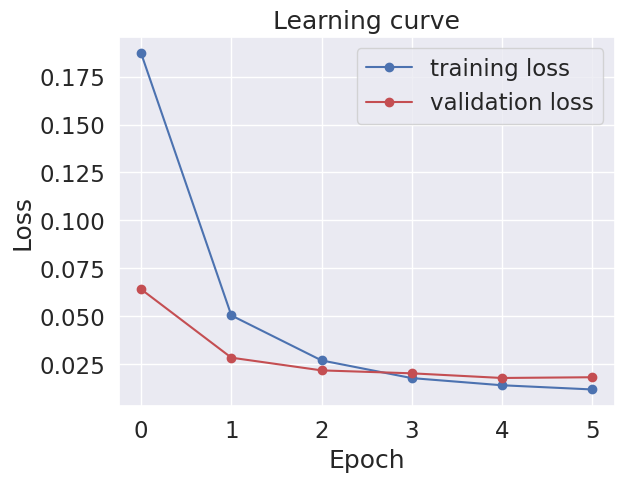

In [12]:
base_path = '/home/nilu/FoodNer/data/'

datasets={'hansard-parent': 'hansard-parent',
  'food-classification':'food-classification',
  
  'hansard-closest':'hansard-closest',
  'foodon': 'foodon',
  'snomedct': 'snomedct'
  #'longest-common-tag-part':'L',
  # 'shortest-tag':'s', 
}

# Loop through each dataset and process it
for version_descriptive, model_version in datasets.items(): 
    # Construct the full path for train and test data
    train_path = base_path + 'train-' + model_version + '.txt'
    test_path = base_path + 'test-' + model_version + '.txt'
    
stored_models = {'bert': 'bert-base-cased',# BERT base model
                 'distilbert': 'distilbert-base-uncased', # DistilBERT base model
     
    'roberta': 'roberta-base',  # RoBERTa base model
      
    # 'bioBert-standard': '/content/drive/My Drive/Colab Notebooks/data/biobert',
    # 'bioBert-large': '/content/drive/My Drive/Colab Notebooks/data/biobert_large'
}


model_tags = {}


train_header='tags'
test_header='-DOCSTART-'
label_adapter = get_label


epochs = 6
max_grad_norm = 1.0

FULL_FINETUNING = True


# Loop through each dataset and process it
for version_descriptive, model_version in datasets.items():
    print()
    print(f"Processing dataset: {version_descriptive}")
    
    

    # Construct the full path for train and test data
    train_path = base_path + 'train-' + model_version + '.txt'
    test_path = base_path + 'test-' + model_version + '.txt'

    # Initialize data
    data = pd.read_csv(train_path, encoding="latin1", delimiter='\t').fillna(method="ffill")
    test_data = pd.read_csv(test_path, encoding="latin1", delimiter='\t').fillna(method="ffill")

    # Process BIO data
    getter, sentences, tag_values, tag2idx, labels = process_bio(data, train_header, label_adapter)

    # Load tag values for each dataset
    if ds_tag_values.get(version_descriptive): 
        print('Loading tag values for:', version_descriptive)
        tag_values = ds_tag_values.get(version_descriptive)
        tag2idx = {t: i for i, t in enumerate(tag_values)}
    else:   
        with open(version_descriptive + ".txt", 'w') as a: 
            print(str(tag_values))
            a.write(str(tag_values))
            model_tags[version_descriptive] = tag_values
    debug_labels_and_tag2idx(labels, tag2idx)
    validate_labels(labels, tag2idx)

    # Loop over each model
    for model_prefix, load_model in stored_models.items():
        reset_model(model_prefix)
        model_name = model_prefix + '-model-' + version_descriptive + '-e' + str(epochs)
        print(model_name)

        # Load model and tokenizer dynamically
        model, tokenizer = get_model_and_tokenizer(load_model, num_labels=len(tag2idx))
        model.to(device)
        


        # Tokenize and prepare data for the specific model
        tokenized_texts_and_labels = [
            tokenize_and_preserve_labels(sent, labs, tokenizer)
            for sent, labs in zip(sentences, labels)
        ]
        

        tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
        labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

        input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                                    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


        tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                            maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                            dtype="long", truncating="post")

        attention_masks = [[float(i != tag2idx["PAD"]) for i in ii] for ii in input_ids]

        tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                                    random_state=2018, test_size=0.1)
        tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                    random_state=2018, test_size=0.1)

        tr_inputs = torch.tensor(tr_inputs).to(device)
        val_inputs = torch.tensor(val_inputs).to(device)
        tr_tags = torch.tensor(tr_tags).to(device)
        val_tags = torch.tensor(val_tags).to(device)
        tr_masks = torch.tensor(tr_masks).to(device)
        val_masks = torch.tensor(val_masks).to(device)


        train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

        valid_data = TensorDataset(val_inputs, val_masks, val_tags)
        valid_sampler = SequentialSampler(valid_data)
        valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)
        


        if FULL_FINETUNING:
            param_optimizer = list(model.named_parameters())
            no_decay = ['bias', 'gamma', 'beta']
            optimizer_grouped_parameters = [
                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                'weight_decay_rate': 0.01},
                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                'weight_decay_rate': 0.0}
            ]
        else:
            param_optimizer = list(model.classifier.named_parameters()) 
            optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

        optimizer = AdamW(
            optimizer_grouped_parameters,        
            lr=3e-5,
            eps=1e-8
        )



        # Total number of training steps is number of batches * number of epochs.
        total_steps = len(train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=0,
            
            num_training_steps=total_steps
        )

        ## Store the average loss after each epoch so we can plot them.
        loss_values, validation_loss_values = [], []

        for _ in trange(epochs, desc="Epoch"):
            # ========================================
            #               Training
            # ========================================
            # Perform one full pass over the training set.
            
            # Put the model into training mode.
            model.train()
            # Reset the total loss for this epoch.
            total_loss = 0

            # Training loop
            for step, batch in enumerate(train_dataloader):
                # add batch to gpu
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                # Always clear any previously calculated gradients before performing a backward pass.
                model.zero_grad()
                # forward pass
                # This will return the loss (rather than the model output)
                # because we have provided the `labels`.
                 #Conditional model call
                if 'distilbert' in model_prefix:
                    # For DistilBERT
                    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                else:
                    # For BERT and RoBERTa
                    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

                #outputs = model(b_input_ids, token_type_ids=None,
                                #attention_mask=b_input_mask, labels=b_labels)
                # get the loss
                loss = outputs[0]
                # Perform a backward pass to calculate the gradients.
                loss.backward()
                # track train loss
                total_loss += loss.item()    
                # Clip the norm of the gradient
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
                # update parameters
                optimizer.step()
                # Update the learning rate.
                scheduler.step()
                
            # Calculate the average loss over the training data.
            avg_train_loss = total_loss / len(train_dataloader)
            print("Average train loss: {}".format(avg_train_loss))
            
            # Store the loss value for plotting the learning curve.
            loss_values.append(avg_train_loss)
            
            
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.
            
            # Put the model into evaluation mode
            model.eval()
            # Reset the validation loss for this epoch.
            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0
            predictions , true_labels = [], []
            
            for batch in valid_dataloader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                
                # Telling the model not to compute or store gradients,
                # saving memory and speeding up validation
                with torch.no_grad():
                    if 'distilbert' in model_prefix:
                        # For DistilBERT
                        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                    else:
                        # For BERT and RoBERTa
                        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                    # Forward pass, calculate logit predictions.
                    # This will return the logits rather than the loss because we have not provided labels.
                    #outputs = model(b_input_ids, token_type_ids=None,
                                    #attention_mask=b_input_mask, labels=b_labels)
                # Move logits and labels to CPU
                logits = outputs[1].detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                
                # Calculate the accuracy for this batch of test sentences.
                eval_loss += outputs[0].mean().item()
                eval_accuracy += flat_accuracy(logits, label_ids)
                predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
                true_labels.append(label_ids)
                
                nb_eval_examples += b_input_ids.size(0)
                nb_eval_steps += 1
            
            eval_loss = eval_loss / nb_eval_steps
            validation_loss_values.append(eval_loss)
            print("Validation loss: {}".format(eval_loss))
            print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
            #pred_tags = [tag_values[p_i] for p in predictions for p_i in p]
            pred_tags = [[tag_values[p_i] for p_i in p] for p in predictions]
            valid_tags = [[tag_values[l_ii] for l_ii in l_i] for l in true_labels for l_i in l]

            #valid_tags = [tag_values[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
            

            print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
            print()


        plt.clf()

        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(loss_values, 'b-o', label="training loss")
        plt.plot(validation_loss_values, 'r-o', label="validation loss")

        # Label the plot.
        plt.title("Learning curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.savefig(model_name+'.png', format='png')



        # Evaluation

        train_labels = labels
        getter, sentences, m, n, labels = process_bio(test_data, test_header, label_adapter)

        ix=0
        correct = labels
        predicted = []

        for s in sentences:
            test_sentence = " ".join(s)
        
            tokenized_sentence = tokenizer.encode(test_sentence)
            input_ids = torch.tensor([tokenized_sentence]).to(device)

        
            with torch.no_grad():
                output = model(input_ids)
            label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

            tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
            new_tokens, new_labels = [], []
            for token, label_idx in zip(tokens, label_indices[0]):
                if token.startswith("##"):
                    new_tokens[-1] = new_tokens[-1] + token[2:]
                else:
                    new_labels.append(tag_values[label_idx])
                    new_tokens.append(token)


            pred=[]
            for wi in range(0, len(labels[ix])):
                pred.append(new_labels[wi+1])
                
            
            predicted.append(pred)
            ix+=1

        correct_flat = [item for sublist in correct for item in sublist]
        predicted_flat = [item for sublist in predicted for item in sublist]


        target_names = set([item for item in itertools.chain(correct_flat, predicted_flat)])
        len(target_names)
        with open(model_name+'.log', 'w+') as log: 
            log.write(classification_report(correct_flat, predicted_flat, target_names=target_names))

        torch.save(model.state_dict(), model_name+'.bin')